# Beta Variational Autoencoder (simple dots)

In this notebook, we will use a beta variational autoencoder ($\beta$-VAE) to encode/decode a simple dataset consisting of a single white dot on a black background.
The $\beta$ term is varied to explore it's impact on reconstruction and latent representation.
For these experiments we'll be using a simple dots dataset that consists of images of a white dot on a black blackground.
This dataset has two ground truth generative factors, the x and y coordinate of the dot.
Therefore, if the latent representation utilizes more than two dimensions, it isn't parsimonious and may not be disentangled.
Likewise if the latent representation only utilizes one latent dimension it isn't disentangled.

## Setup

In [1]:
import sconce
print(f"This notebook was run using sconce {sconce.__version__}")

This notebook was run using sconce 1.3.0


### Define plot_traversal function

We'll make extensive use of this function to explore the latent representations encoded by our $\beta$-VAEs.
This function takes and encodes a single input image, and then shows how varying each latent variable
affects the reconstruction.
Burgess et. al. describe latent traversals in figure 2 [here](http://arxiv.org/abs/1804.03599).

In [2]:
from matplotlib import pyplot as plt
import numpy as np

def plot_traversal(trainer, index=0, figure_width=10.5, num_cols=9, image_height=1.5):
    """
    Plot a traversal of the latent space.
    
    Steps are:
        1) encode an input to a latent representation
        2) adjust each latent value from -3 to 3 while keeping other values fixed
        3) decode each adjusted latent representation
        4) display
    """
    sample, target = trainer.validation_feed.dataset[index]
    sample_batch = sample[None].cuda()
    trainer.model.train(False)
    mu, logvar = trainer.model.encode(sample_batch)
    z = mu  # since we're not training, no noise is added
    
    num_rows = z.shape[-1]
    num_cols = num_cols
    
    fig = plt.figure(figsize=(figure_width, image_height * num_rows))
    
    for i in range(num_rows):
        z_i_values = np.linspace(-3.0, 3.0, num_cols)
        z_i = z[0][i].detach().cpu().numpy()
        z_diffs = np.abs((z_i_values - z_i))
        j_min = np.argmin(z_diffs)
        for j in range(num_cols):
            z_i_value = z_i_values[j]
            if j != j_min:
                z[0][i] = z_i_value
            else:
                z[0][i] = float(z_i)
                
            x = trainer.model.decode(z).detach().cpu().numpy()
            
            ax = fig.add_subplot(num_rows, num_cols, i * num_cols + j + 1)
            ax.imshow(x[0][0], cmap='gray')
            
            if i == 0 or j == j_min:
                ax.set_title(f'{z[0][i]:.1f}')
            
            if j == j_min:
                ax.set_xticks([], [])
                ax.set_yticks([], []) 
                color = 'mediumseagreen'
                width = 8
                for side in ['top', 'bottom', 'left', 'right']:
                    ax.spines[side].set_color(color)
                    ax.spines[side].set_linewidth(width)
            else:
                ax.axis('off')
        z[0][i] = float(z_i)
        
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.04)

In [3]:
from sconce.data_feeds import ImageFeed
from sconce.datasets import SimpleDots

dataset = SimpleDots(image_size=(62, 62), circle_radius=8, num_images=3_000)
training_feed = ImageFeed.from_dataset(dataset, batch_size=200, num_workers=7, shuffle=True)

In [4]:
import torch
from torch import optim
from sconce.trainers import AutoencoderTrainer
from sconce.models import VariationalAutoencoder

def get_trainer(conv_channels=[32, 32, 32, 32], hidden_sizes=[256, 256], latent_size=5):
    model = VariationalAutoencoder(conv_channels=conv_channels,
                                   hidden_sizes=hidden_sizes,
                                   image_channels=1,
                                   image_size=dataset.image_size,
                                   latent_size=latent_size)
    
    if torch.cuda.is_available():
        model.cuda()
        training_feed.cuda()
        
    model.set_optimizer(optim.Adam, lr=1e-1)

    trainer = AutoencoderTrainer(model=model,
        training_feed=training_feed,
        validation_feed=training_feed)
    trainer.validation_to_train_ratio = 0
    return trainer

## Results (Low Beta Value)

This set of hyperparameters is quite reliable in getting a latent representation that uses 3+ of the latent dimensions.

105/149 [====================>.........] - ETA: 1s - loss: 0.7807
Scheduled training termination: Exponential Schedule stop condition met.


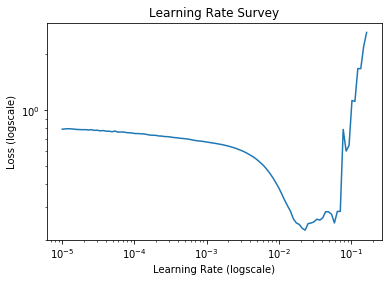

In [5]:
trainer = get_trainer()
monitor = trainer.survey_learning_rate(num_epochs=10, min_learning_rate=1e-5, max_learning_rate=10)
monitor.dataframe_monitor.plot_learning_rate_survey()

2970/2970 [==============================] - 114s 38ms/step - loss: 0.0350


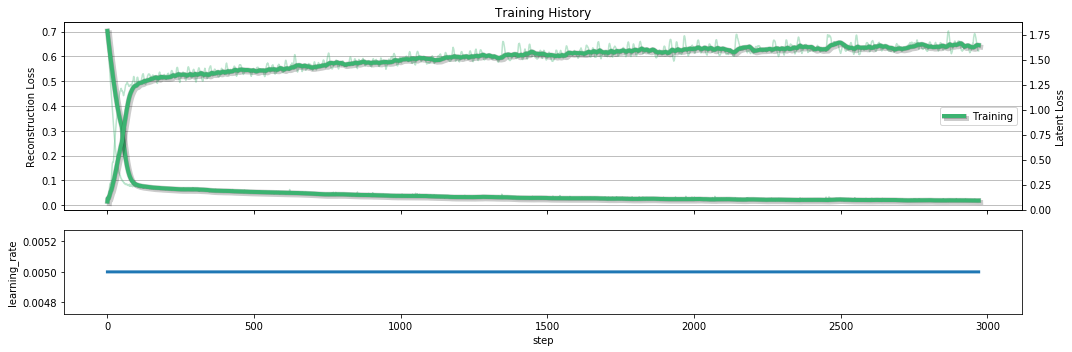

In [6]:
trainer = get_trainer()
trainer.model.set_schedule('learning_rate', 5e-3)
trainer.model.set_schedule('beta', 0.01)
monitor = trainer.train(num_epochs=200)
monitor.dataframe_monitor.plot(skip_first=0, metrics=['reconstruction_loss', 'latent_loss']);

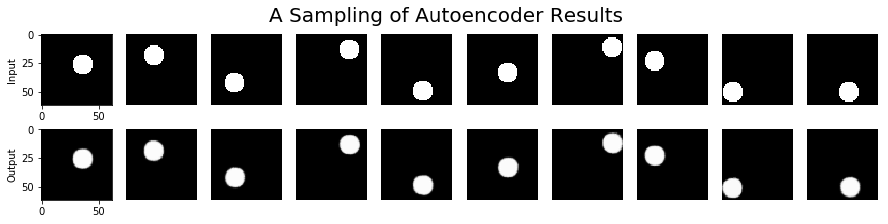

In [7]:
trainer.plot_input_output_pairs();

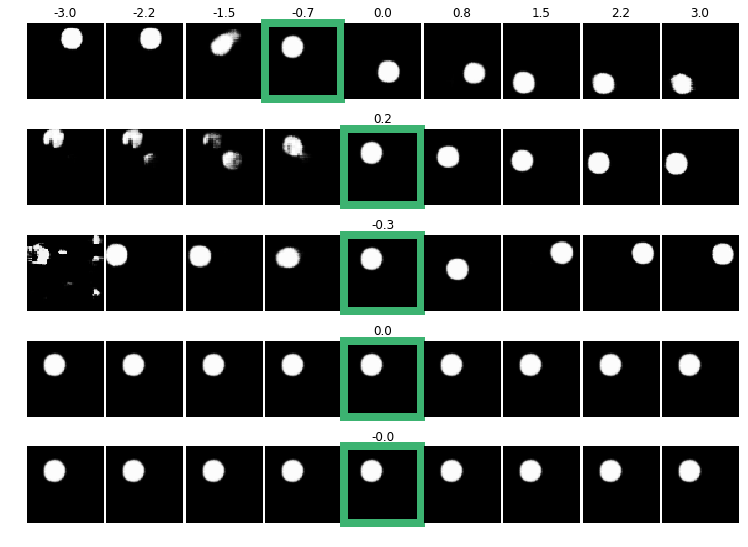

In [8]:
plot_traversal(trainer, index=950)

## Results (High Beta Value)

This set of training hyperparameters gets you either fully confused reconstructions (big white squares) or a latent representation that only uses one of the five latent dimensions.
It seems about equally likely (based on random initialization) to do one of those two things.

5940/5940 [==============================] - 226s 38ms/step - loss: 0.2117


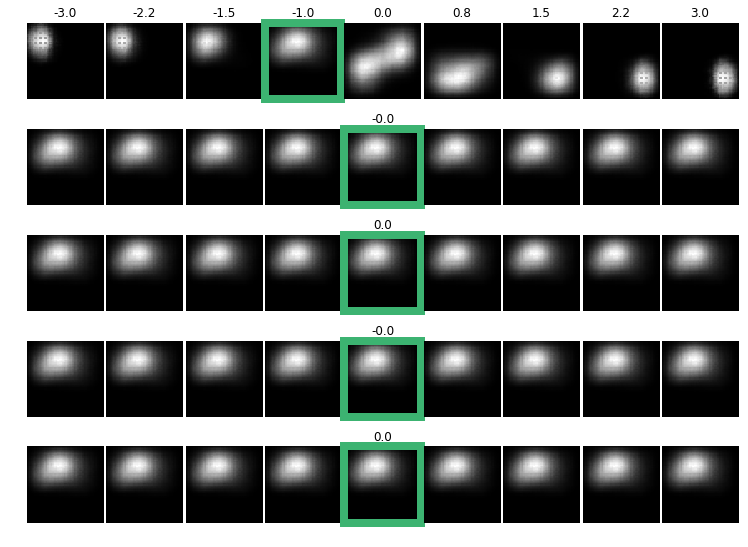

In [9]:
high_beta_trainer = get_trainer()
high_beta_trainer.model.set_schedule('learning_rate', 5e-3)
high_beta_trainer.model.set_schedule('beta', 0.25)
high_beta_trainer.train(num_epochs=400)
plot_traversal(high_beta_trainer, index=950)

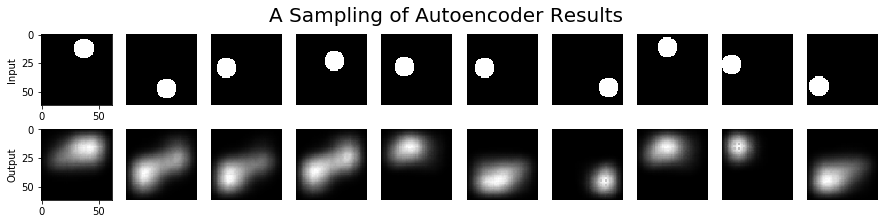

In [10]:
high_beta_trainer.plot_input_output_pairs();

## Results (Critical Beta Value)

This set of training hyperparameters seems like it gets the desired disentangled latent representation about 1 in 3 runs.

In [11]:
critical_beta_trainer = get_trainer()
critical_beta_trainer.model.set_schedule('learning_rate', 5e-3)
critical_beta_trainer.model.set_schedule('beta', 0.125)
critical_beta_trainer.train(num_epochs=400)

5940/5940 [==============================] - 228s 38ms/step - loss: 0.1448


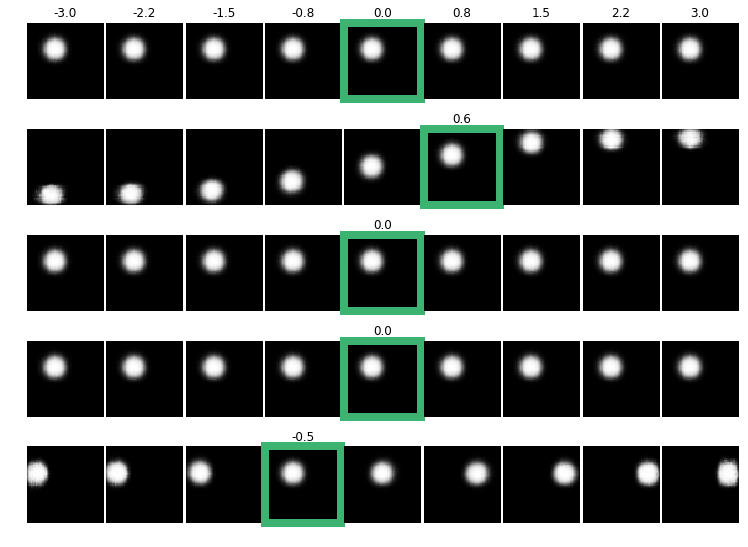

In [12]:
plot_traversal(critical_beta_trainer, index=951)

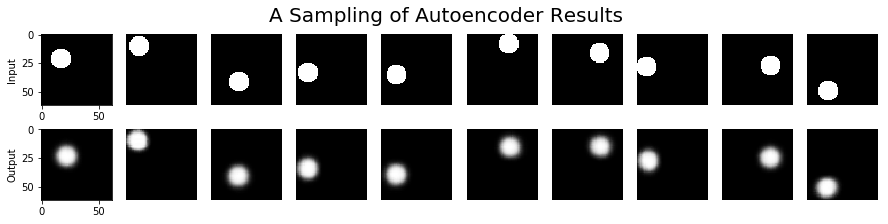

In [13]:
critical_beta_trainer.plot_input_output_pairs();

## Adjusting beta during training

These hyperparameters are also pretty reliable at getting a good disentangled latent representation and good reconstruction quality.
About one in five runs this will have a latent representation that either tries to use only one latent dimension, uses three.

In [14]:
from sconce.schedules import Cosine

adjusting_trainer = get_trainer()
adjusting_trainer.model.set_schedule('learning_rate', 5e-3)
adjusting_trainer.model.set_schedule('beta', Cosine(initial_value=0.001, final_value=0.3))
adjusting_trainer.train(num_epochs=200)

adjusting_trainer.model.set_schedule('beta', Cosine(initial_value=0.3, final_value=0.001))
adjusting_trainer.train(num_epochs=600)

8910/8910 [==============================] - 344s 39ms/step - loss: 0.0169


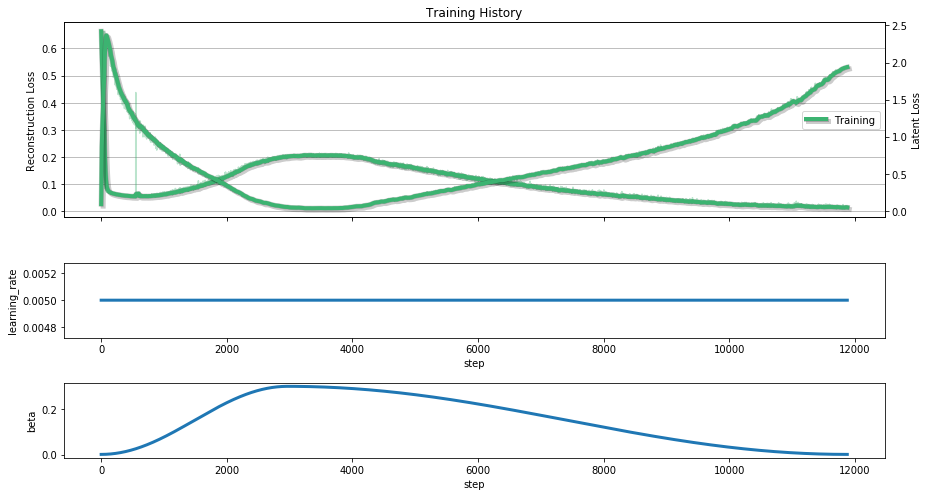

In [15]:
adjusting_trainer.monitor.dataframe_monitor.plot(figsize=(13, 7), skip_first=0,
                               metrics=['reconstruction_loss', 'latent_loss'],
                               hyperparameters=[{'name': 'learning_rate'},
                                                {'name': 'beta'}]
                              );

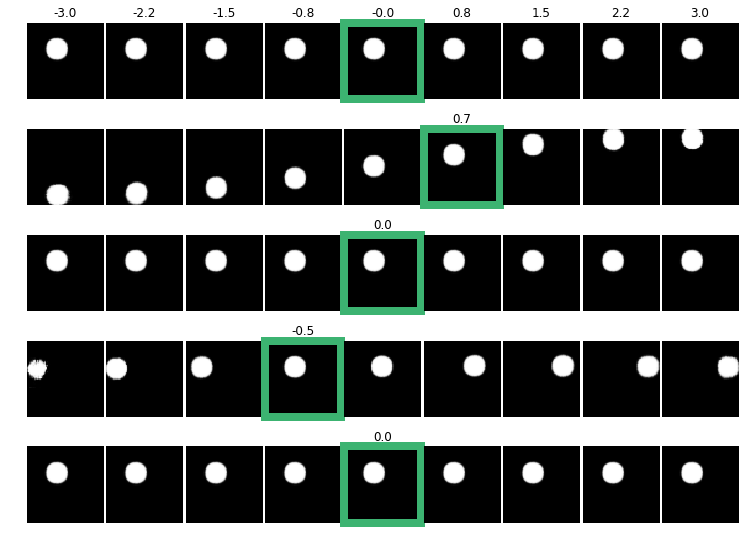

In [16]:
plot_traversal(adjusting_trainer, index=950)

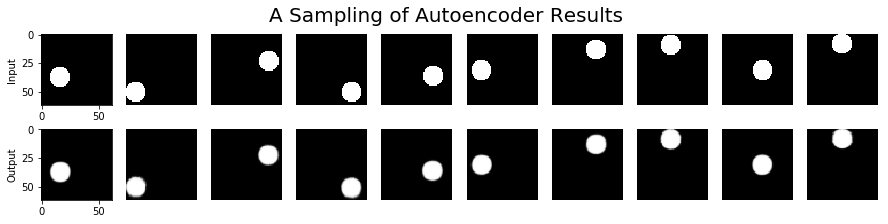

In [17]:
adjusting_trainer.plot_input_output_pairs();